# Analysis of Charles Murray's Basic Income Plan

Details from http://www.fljs.org/files/publications/Murray.pdf, based on *In Our Hands* (2006).

Key elements summarized in [Ghenis (2017)](https://medium.com/@MaxGhenis/the-case-for-a-person-centric-basic-income-plan-55e90010fc9e) include:

* Annual amount: \\$10,000, plus \$3,000 to purchase catastrophic health insurance.
* Eligible population: citizens age 21+.
* Replaced plans: “Social Security, Medicare, Medicaid, welfare programmes, social service programmes, agricultural subsidies, and corporate welfare.” Per [The Atlantic (2006)](https://www.theatlantic.com/magazine/archive/2006/04/why-murrays-big-idea-wont-work/304830/), unemployment insurance will also end.
* Tax changes: 17% phase-out of basic income for incomes between \\$30,000 to \\$60,000 (\\$5,000 for incomes above \\$60,000).\*

This analysis considers only the \$10,000 amount, repealing non-healthcare safety net programs to avoid considering the effect on employer-sponsored health insurance.

Note: The US has experience 27% cumulative inflation since 2006.

TODO: Wait on new Medicare/Medicaid values.

\* *Murray's [2016 article](http://www.aei.org/publication/a-guaranteed-income-for-every-american/) says "After \\$30,000, a graduated surtax reimburses part of the grant, which would drop to \\$6,500 (but no lower) when an individual reaches \\$60,000 of earned income." This includes the \\$3,000 health insurance stipend.*

## Setup

### Imports

In [1]:
import taxcalc as tc
import microdf as mdf
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'2.3.0'

### Settings

In [3]:
sns.set_style('white')
DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Number of decimals when printing pandas DataFrames.
pd.set_option('precision', 2)

### Utilities

In [6]:
def quantile_summary(df, groupby):
    qs = df.groupby(groupby).sum()
    add_ratios(qs)
    # Exclude 0, the negative group.
    return qs.loc[1:]

### Constants

In [7]:
UBI = 10000.
PS_START = 30000.  # Per n21.
PS_END = 60000.  # Per n21.
MIN_UBI = 5000.  # For tax units with agi >= PS_END * n21.
UBI_MULT = 1.57 / 1.90  # For revenue neutrality.

In [8]:
round(UBI * UBI_MULT)

15474

## Data

In [9]:
tu = mdf.calc_df(year=2019, group_n65=True, 
                 group_vars=['n21', 'nu18', 'c00100', 'XTOT'])

In [10]:
tu.rename(columns={'aftertax_income': 'afti_base'}, inplace=True)

## Preprocess

### Add UBI, benefit total, and difference

In [11]:
def phase_out(inc, max_amount, min_amount, ps_start, ps_end):
    ps = (max_amount - min_amount) / (ps_end - ps_start)
    return np.where(inc <= ps_start, max_amount,
                    np.where(inc >= ps_end, min_amount,
                             max_amount - (ps * (inc - ps_start))))

In [12]:
tu['c00100_per_n21'] = tu.c00100 / tu.n21
tu['ubi_per_n21'] = UBI_MULT * phase_out(
    tu.c00100_per_n21, UBI, MIN_UBI, PS_START, PS_END)
tu['ubi'] = np.where(tu.n21 == 0, 0, tu.n21 * tu.ubi_per_n21)

In [13]:
tu['ubi_minus_bens'] = tu.ubi - tu.bens

In [14]:
tu['afti_ubi'] = tu.afti_base + tu.ubi_minus_bens
tu['afti_ubi_pp'] = tu.afti_ubi / tu.XTOT

In [15]:
mdf.weighted_sum(tu, 'ubi_minus_bens') / 1e9

-1.2594871672409351

In [16]:
mdf.weighted_sum(tu, 'afti_base') / 1e12

12.461565525833244

In [17]:
mdf.weighted_sum(tu, 'afti_ubi') / 1e12

12.460306038666007

### Add quantiles

In [18]:
tu['afti_base_pp'] = tu.afti_base / tu.XTOT
mdf.add_weighted_metrics(tu, 'XTOT')
for i in ['afti_base', 'afti_base_pp', 'expanded_income']:
    mdf.add_weighted_quantiles(tu, i, 'XTOT_m')

### Other additional columns

In [19]:
tu['nu18_bucket'] = np.where(tu.nu18 < 3, tu.nu18.astype('int'), '3+')
tu['has_nu18'] = tu.nu18 > 0
tu['has_e02400'] = tu.e02400 > 0  # OASDI.
tu['has_n65'] = tu.n65 > 0

Check distribution of people by whether their tax unit has minors or OASDI recipients.

In [20]:
(100 * tu.groupby(['has_nu18', 'has_n65']).XTOT_m.sum() / 
 tu.XTOT_m.sum()).reset_index()

,has_nu18,has_n65,XTOT_m
0,False,False,33.63
1,False,True,16.50
2,True,False,47.70
3,True,True,2.17


### Weighted sums

In [21]:
tu[['afti_base', 's006']].sample(10)

,afti_base,s006
RECID,,
182259,103890.34,164.12
10278,187591.82,55.23
8049,249991.91,751.73
40143,242088.01,45.09
119854,229083.10,72.55
41953,202386.92,59.69
343069,84712.65,377.80
31241,173522.90,82.24
142118,91447.69,282.24


WTF is going on here???

Something about using s006 in the arg?

In [22]:
# Add weighted sums.
mdf.add_weighted_metrics(tu, ['expanded_income', 'afti_base',
                              'afti_ubi', 'XTOT', 'nu18', 'n65'])

In [23]:
tu.afti_base_m.sum() / 1e6

12.461565525833254

In [24]:
tu.afti_ubi_m.sum() / 1e6

12.460306038666005

### Summarize quantiles

In [25]:
def add_ratios(df):
    df['afti_base_pp'] = df.afti_base_m / df.XTOT_m
    df['afti_ubi_pp'] = df.afti_ubi_m / df.XTOT_m
    df['afti_chg_m'] = df.afti_ubi_m - df.afti_base_m
    df['afti_pctchg'] = 100 * df.afti_chg_m / df.afti_base_m

SUM_COLS = ['s006', 'XTOT_m', 'afti_base_m', 'afti_ubi_m']

def quantile_summary(df, groupby):
    qs = df.groupby(groupby)[SUM_COLS].sum()
    add_ratios(qs)
    # Exclude 0, the negative group.
    return qs.loc[1:]

In [26]:
add_ratios(tu)
tu['abs_afti_pctchg'] = tu.afti_pctchg.abs()

In [27]:
quart = quantile_summary(tu, 'afti_base_pp_quartile')
quint = quantile_summary(tu, 'afti_base_pp_quintile')
dec = quantile_summary(tu, 'afti_base_pp_decile')
vent = quantile_summary(tu, 'afti_base_pp_ventile')
twopct = quantile_summary(tu, 'afti_base_pp_2percentile')
pct = quantile_summary(tu, 'afti_base_pp_percentile')

In [28]:
dec

,s006,XTOT_m,afti_base_m,afti_ubi_m,afti_base_pp,afti_ubi_pp,afti_chg_m,afti_pctchg
afti_base_pp_decile,,,,,,,,
1,1.40e+07,33.21,2.15e+05,4.36e+05,6470.87,13112.22,220586.39,102.63
2,1.21e+07,33.31,4.23e+05,5.80e+05,12700.55,17417.86,157148.75,37.14
3,1.25e+07,33.31,5.53e+05,6.36e+05,16587.04,19077.71,82967.92,15.02
4,1.37e+07,33.31,6.71e+05,7.32e+05,20158.11,21988.88,60986.02,9.08
5,1.53e+07,33.31,8.05e+05,8.63e+05,24169.13,25914.33,58136.94,7.22
6,1.77e+07,33.31,9.74e+05,1.00e+06,29239.06,30095.39,28525.89,2.93
7,1.91e+07,33.31,1.19e+06,1.15e+06,35700.35,34509.43,-39673.46,-3.34
8,1.97e+07,33.31,1.50e+06,1.40e+06,44881.97,42046.30,-94461.71,-6.32
9,2.02e+07,33.31,2.00e+06,1.80e+06,59961.96,54068.36,-196323.56,-9.83


In [29]:
quart_by_nu18b = quantile_summary(tu, ['afti_base_pp_quartile', 'nu18_bucket'])
quint_by_nu18b = quantile_summary(tu, ['afti_base_pp_quintile', 'nu18_bucket'])
dec_by_nu18b = quantile_summary(tu, ['afti_base_pp_decile', 'nu18_bucket'])
vent_by_nu18b = quantile_summary(tu, ['afti_base_pp_ventile', 'nu18_bucket'])
twopct_by_nu18b = quantile_summary(tu, ['afti_base_pp_2percentile', 'nu18_bucket'])
pct_by_nu18b = quantile_summary(tu, ['afti_base_pp_percentile', 'nu18_bucket'])

In [30]:
quart_by_nu18 = quantile_summary(tu, ['afti_base_pp_quartile', 'has_nu18'])
quint_by_nu18 = quantile_summary(tu, ['afti_base_pp_quintile', 'has_nu18'])
dec_by_nu18 = quantile_summary(tu, ['afti_base_pp_decile', 'has_nu18'])
vent_by_nu18 = quantile_summary(tu, ['afti_base_pp_ventile', 'has_nu18'])
twopct_by_nu18 = quantile_summary(tu, ['afti_base_pp_2percentile', 'has_nu18'])
pct_by_nu18 = quantile_summary(tu, ['afti_base_pp_percentile', 'has_nu18'])

In [31]:
quart_by_n65 = quantile_summary(tu, ['afti_base_pp_quartile', 'has_n65'])
quint_by_n65 = quantile_summary(tu, ['afti_base_pp_quintile', 'has_n65'])
dec_by_n65 = quantile_summary(tu, ['afti_base_pp_decile', 'has_n65'])
vent_by_n65 = quantile_summary(tu, ['afti_base_pp_ventile', 'has_n65'])
twopct_by_n65 = quantile_summary(tu, ['afti_base_pp_2percentile', 'has_n65'])
pct_by_n65 = quantile_summary(tu, ['afti_base_pp_percentile', 'has_n65'])

## Analysis

### Totals

In [32]:
XTOT_in_tus_0_n21_m = tu[tu.n21 == 0].XTOT_m.sum()
print(('{:.1f} million people ({:.1f}% of all people) are in tax units ' +
       'without an adult over age 21.').format(
    XTOT_in_tus_0_n21_m, 100 * XTOT_in_tus_0_n21_m / tu.XTOT_m.sum()))

7.0 million people (2.1% of all people) are in tax units without an adult over age 21.


In [33]:
print(
    'Total benefit value: ${:,.2f}T'.format(
        mdf.weighted_sum(tu, 'bens') / 1e12) + '\n' +
    'Total proposed UBI: ${:,.2f}T'.format(
        mdf.weighted_sum(tu, 'ubi') / 1e12))

Total benefit value: $2.94T
Total proposed UBI: $2.94T


### Quantile distributions

In [34]:
def quantile_plot(df, legend_title, xlabel, title):
    fig = plt.figure()
    ax = df.unstack(level=1).afti_pctchg.plot()
    plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
    if legend_title is not None:
        plt.legend(title=legend_title)
    sns.despine(left=True, bottom=True)
    ax.set(xlabel=xlabel, ylabel='Change to income after taxes and transfers')
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y / 100)))
    plt.title(title, loc='left')
    #return(fig)
    plt.show()

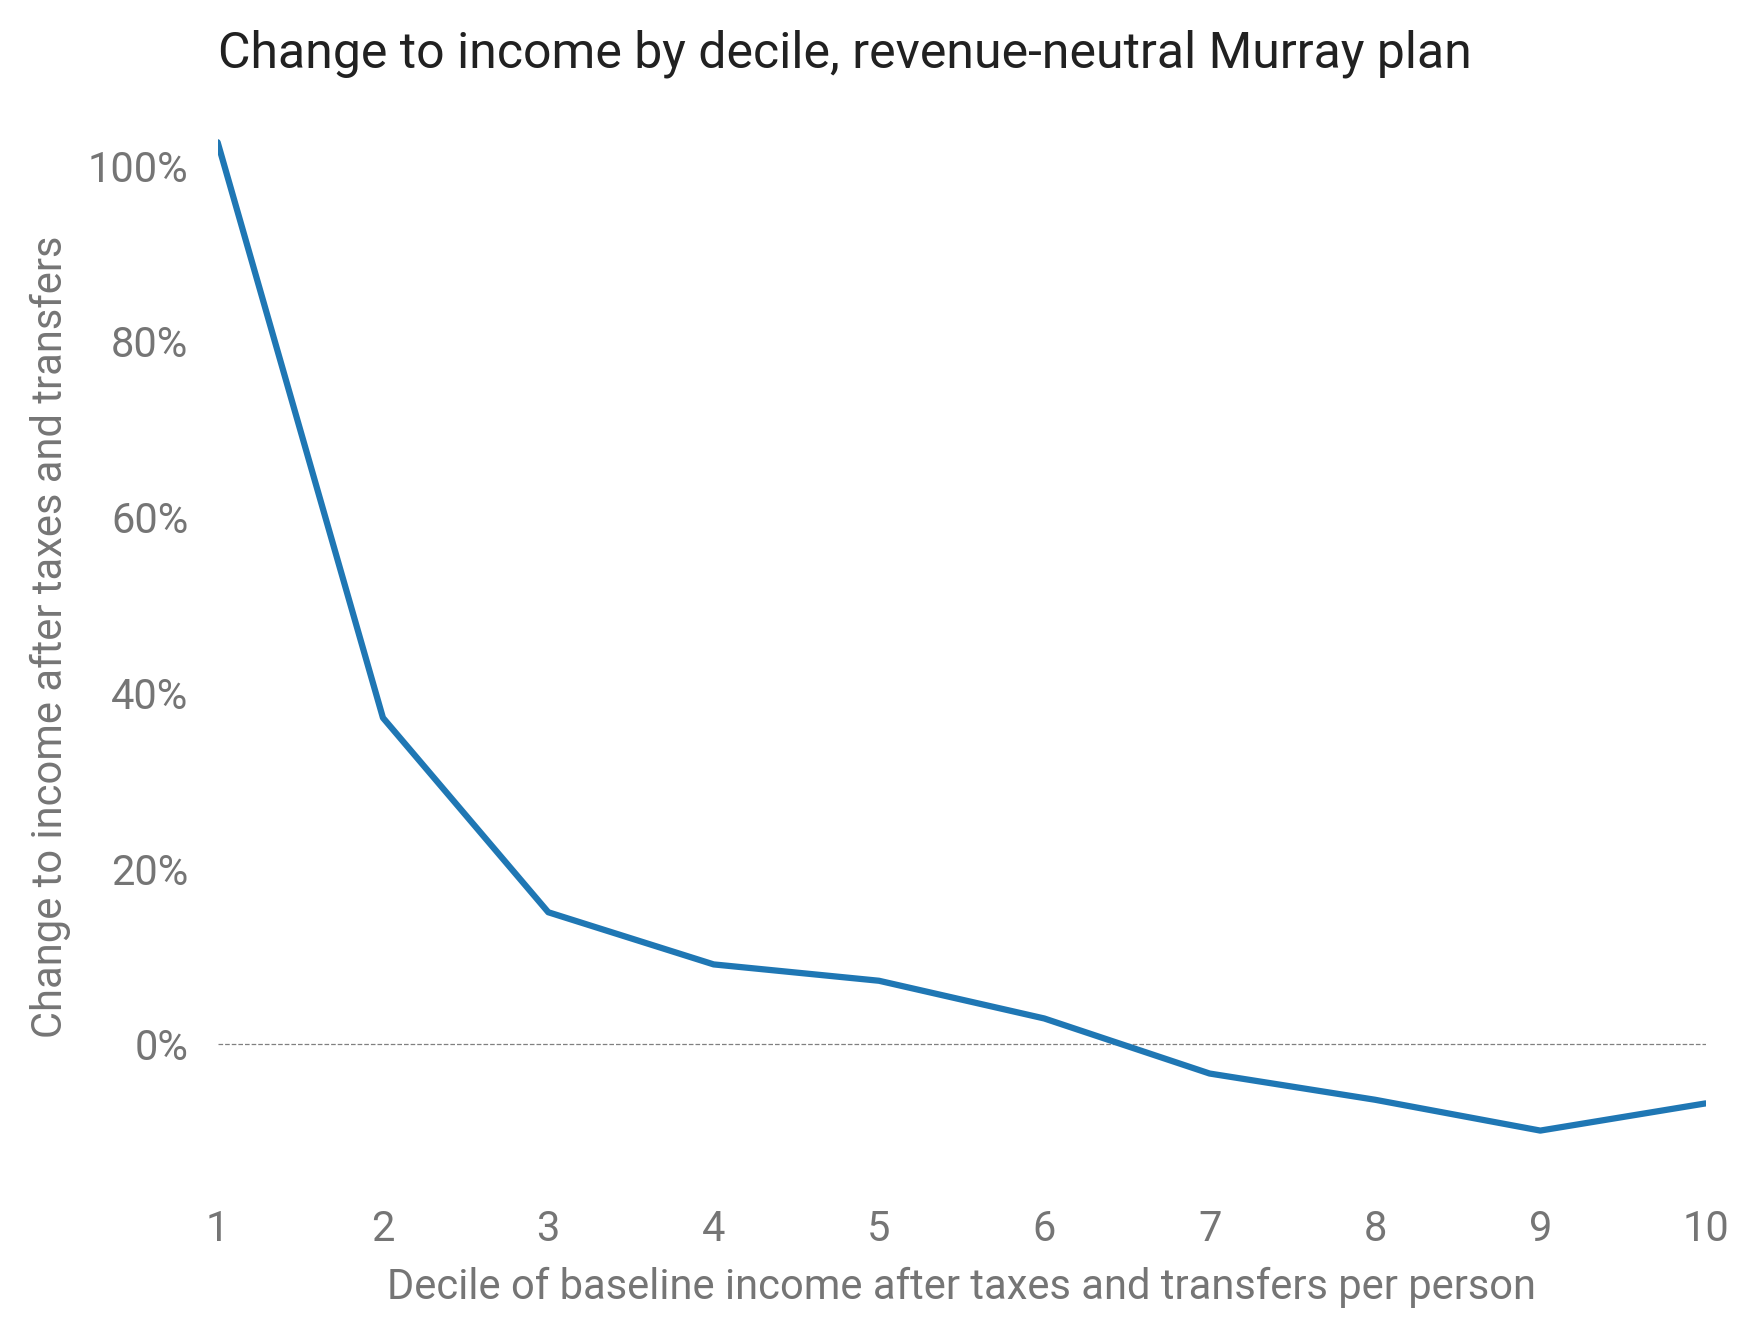

In [35]:
ax = quantile_plot(dec, 
                   None, 
                   'Decile of baseline income after taxes and transfers ' +
                   'per person',
                   'Change to income by decile, ' +
                   'revenue-neutral Murray plan')

<Figure size 1920x1440 with 0 Axes>

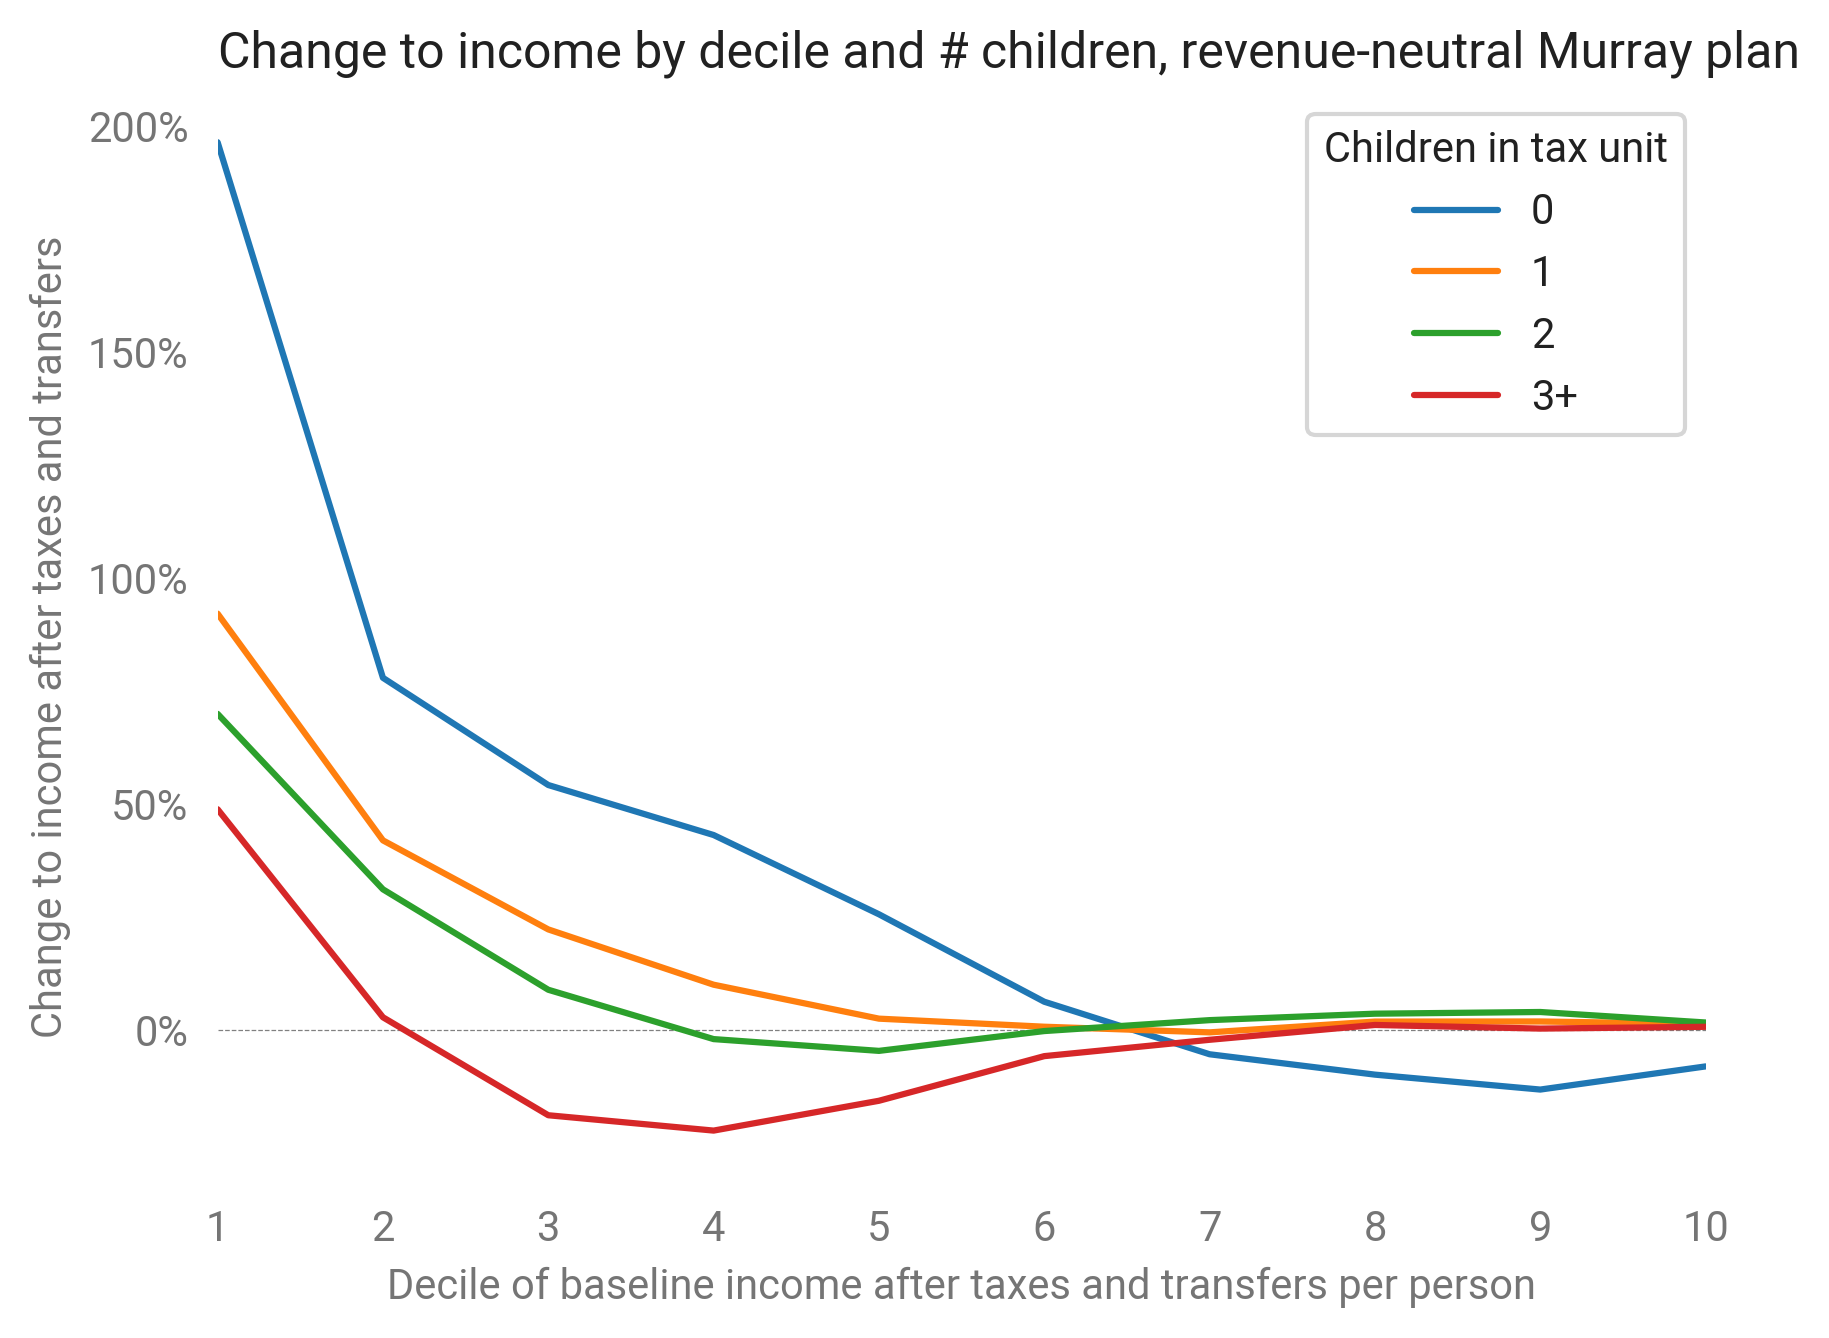

In [36]:
quantile_plot(dec_by_nu18b, 
              'Children in tax unit', 
              'Decile of baseline income after taxes and transfers per person',
              'Change to income by decile and # children, ' +
              'revenue-neutral Murray plan')
plt.show()

<Figure size 1920x1440 with 0 Axes>

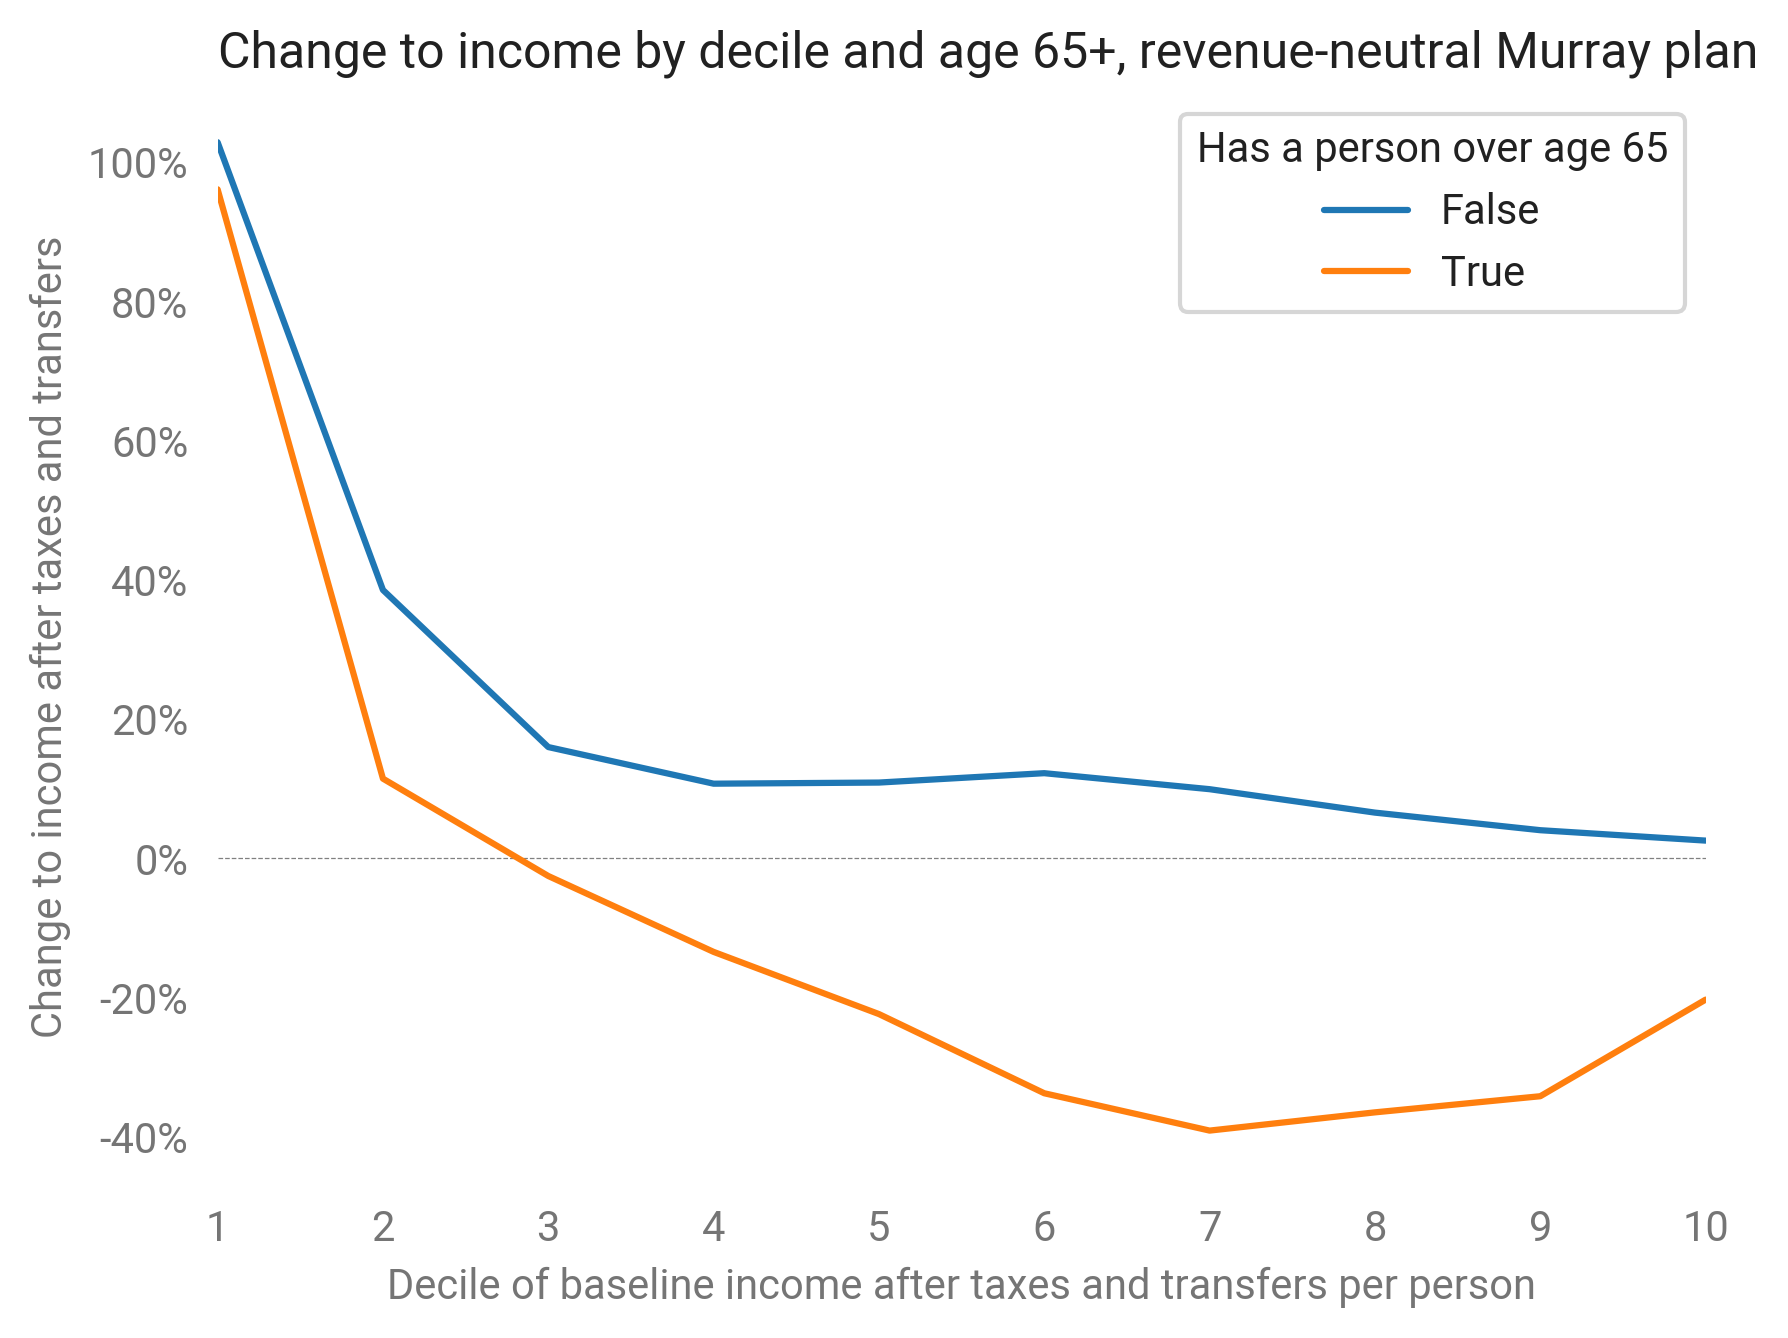

In [37]:
quantile_plot(dec_by_n65, 
              'Has a person over age 65', 
              'Decile of baseline income after taxes and transfers ' +
              'per person',
              'Change to income by decile and age 65+, ' +
              'revenue-neutral Murray plan')
plt.show()

### Inequality

In [38]:
mdf.gini(tu.afti_base, tu.s006)

0.4537610474879133

In [39]:
mdf.gini(tu.afti_ubi, tu.s006)

0.44374162440397236

In [40]:
mdf.gini(tu.afti_base_pp, tu.XTOT_m)

0.4379035217991987

In [41]:
mdf.gini(tu.afti_ubi_pp, tu.XTOT_m)

0.4197097044507119

### Poverty

In [42]:
tu['fpl'] = mdf.fpl(tu.XTOT)
tu['fpl_pp'] = tu.fpl / tu.XTOT
# Using $10k per person.
tu['pov_10k'] = 10000 * tu.XTOT
# $1.90 per day in 2011 dollars = $2.10 in 2018 dollars = $780/year.
EXTREME_POVERTY_LINE = 780
tu['extreme_pov'] = EXTREME_POVERTY_LINE * tu.XTOT

In [43]:
def pov_rate(metric, afti, pov_line):
    return ((tu[metric] * (tu[afti] < tu[pov_line])).sum() / 
                      tu[metric].sum())

In [44]:
AFTI_COLS = ['afti_base', 'afti_ubi']
pov = pd.DataFrame([(metric, afti, pov_line) 
                    for metric in ['XTOT_m', 'nu18_m', 'n65_m']
                    for afti in AFTI_COLS
                    for pov_line in ['fpl', 'pov_10k', 'extreme_pov']])
pov.columns = ['metric', 'afti', 'pov_line']
pov['pov_rate'] = pov.apply(lambda x: pov_rate(x.metric, x.afti, x.pov_line), 
                            axis=1)

In [45]:
pov

,metric,afti,pov_line,pov_rate
0,XTOT_m,afti_base,fpl,5.04e-02
1,XTOT_m,afti_base,pov_10k,9.24e-02
2,XTOT_m,afti_base,extreme_pov,8.96e-03
3,XTOT_m,afti_ubi,fpl,4.19e-02
4,XTOT_m,afti_ubi,pov_10k,7.31e-02
5,XTOT_m,afti_ubi,extreme_pov,3.80e-03
6,nu18_m,afti_base,fpl,5.00e-02
7,nu18_m,afti_base,pov_10k,1.33e-01
8,nu18_m,afti_base,extreme_pov,9.50e-03
9,nu18_m,afti_ubi,fpl,8.65e-02


In [46]:
pov_wide_XTOT = pov[pov.metric == 'XTOT_m'].pivot_table(
    index='pov_line', columns='afti')
pov_wide_XTOT.columns = AFTI_COLS
pov_wide_XTOT = pov_wide_XTOT[AFTI_COLS]

pov_wide_nu18 = pov[pov.metric == 'nu18_m'].pivot_table(
    index='pov_line', columns='afti')
pov_wide_nu18.columns = AFTI_COLS
pov_wide_nu18 = pov_wide_nu18[AFTI_COLS]

pov_wide_n65 = pov[pov.metric == 'n65_m'].pivot_table(
    index='pov_line', columns='afti')
pov_wide_n65.columns = AFTI_COLS
pov_wide_n65 = pov_wide_n65[AFTI_COLS]

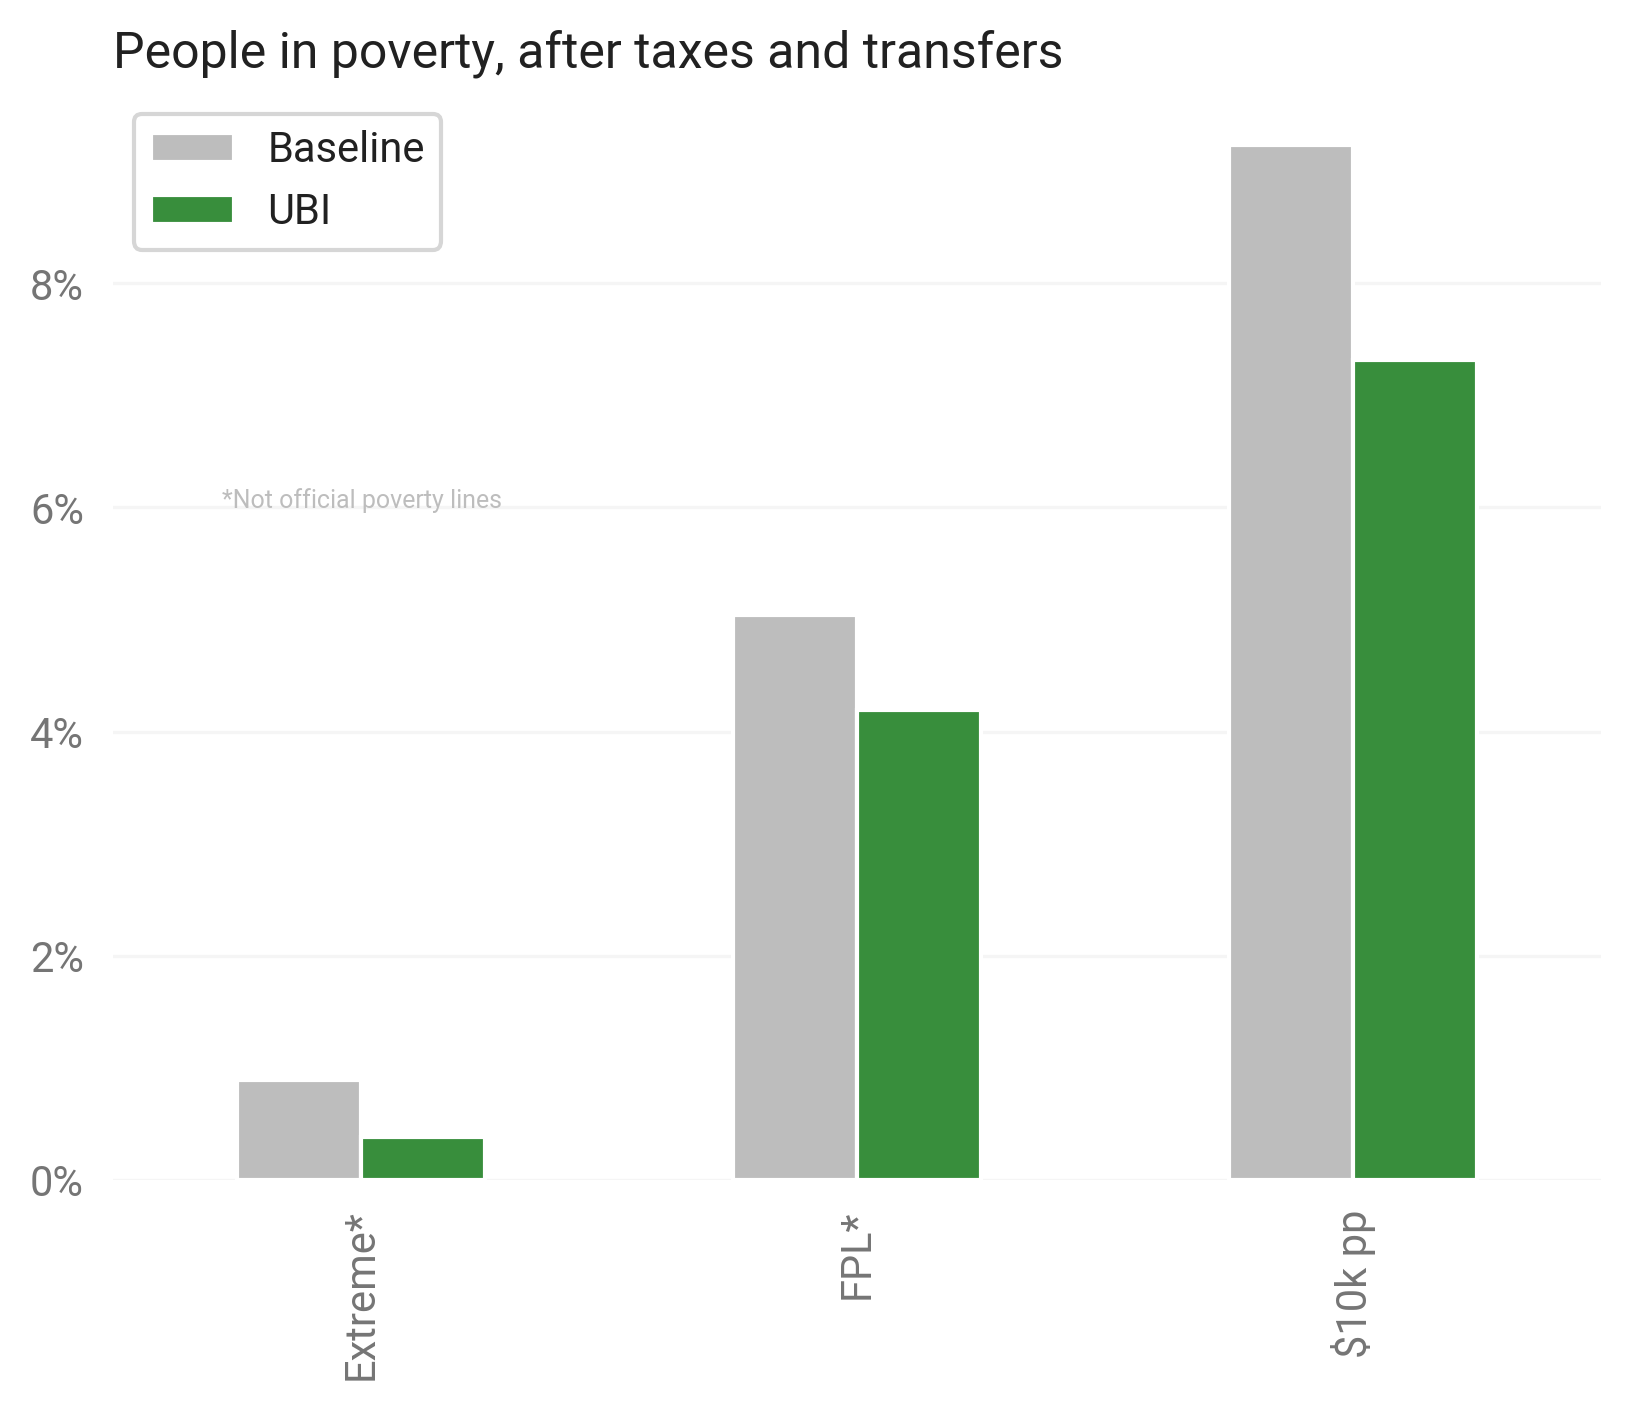

In [47]:
KEEP_COLOR = '#bdbdbd'  # Light gray from material.io/color.
UBI_COLOR = '#388e3c'
ax = pov_wide_XTOT.plot.bar(color=[KEEP_COLOR, UBI_COLOR])
ax.set_xticklabels(('Extreme*', 'FPL*', '$10k pp'))
sns.despine(left=True, bottom=True)
# Use text instead of legend.
# ax.legend_.remove()
LEFT_X = -0.28
ax.legend(['Baseline', 'UBI'])
# ax.text(LEFT_X, 0.235, 'Repeal CTC', horizontalalignment='left',
#         color=REPEAL_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.225, 'No change to CTC', horizontalalignment='left',
#         color=KEEP_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.215, rn_ubi_str + ' child benefit', 
#         horizontalalignment='left', color=UBI_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.205, '$2,000 child benefit', 
#         horizontalalignment='left', color=TUBI_COLOR, size=8, weight='bold')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
plt.title('People in poverty, after taxes and transfers', 
          loc='left')
ax.text(LEFT_X, 0.06, '*Not official poverty lines',
        horizontalalignment='left', color=KEEP_COLOR, size=6)
ax.set(xlabel='')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

In [48]:
pov_wide_nu18

,afti_base,afti_ubi
pov_line,,
extreme_pov,9.50e-03,7.45e-03
fpl,5.00e-02,8.65e-02
pov_10k,1.33e-01,1.63e-01


In [49]:
pov_wide_XTOT

,afti_base,afti_ubi
pov_line,,
extreme_pov,8.96e-03,3.80e-03
fpl,5.04e-02,4.19e-02
pov_10k,9.24e-02,7.31e-02


In [50]:
pov_wide_nu18.afti_ubi / pov_wide_nu18.afti_base - 1

pov_line
extreme_pov   -0.22
fpl            0.73
pov_10k        0.23
dtype: float64

In [51]:
pov_wide_n65.afti_ubi / pov_wide_n65.afti_base - 1

pov_line
extreme_pov   -0.87
fpl            1.24
pov_10k        0.73
dtype: float64

In [52]:
pov_wide_XTOT.afti_ubi / pov_wide_XTOT.afti_base - 1

pov_line
extreme_pov   -0.58
fpl           -0.17
pov_10k       -0.21
dtype: float64

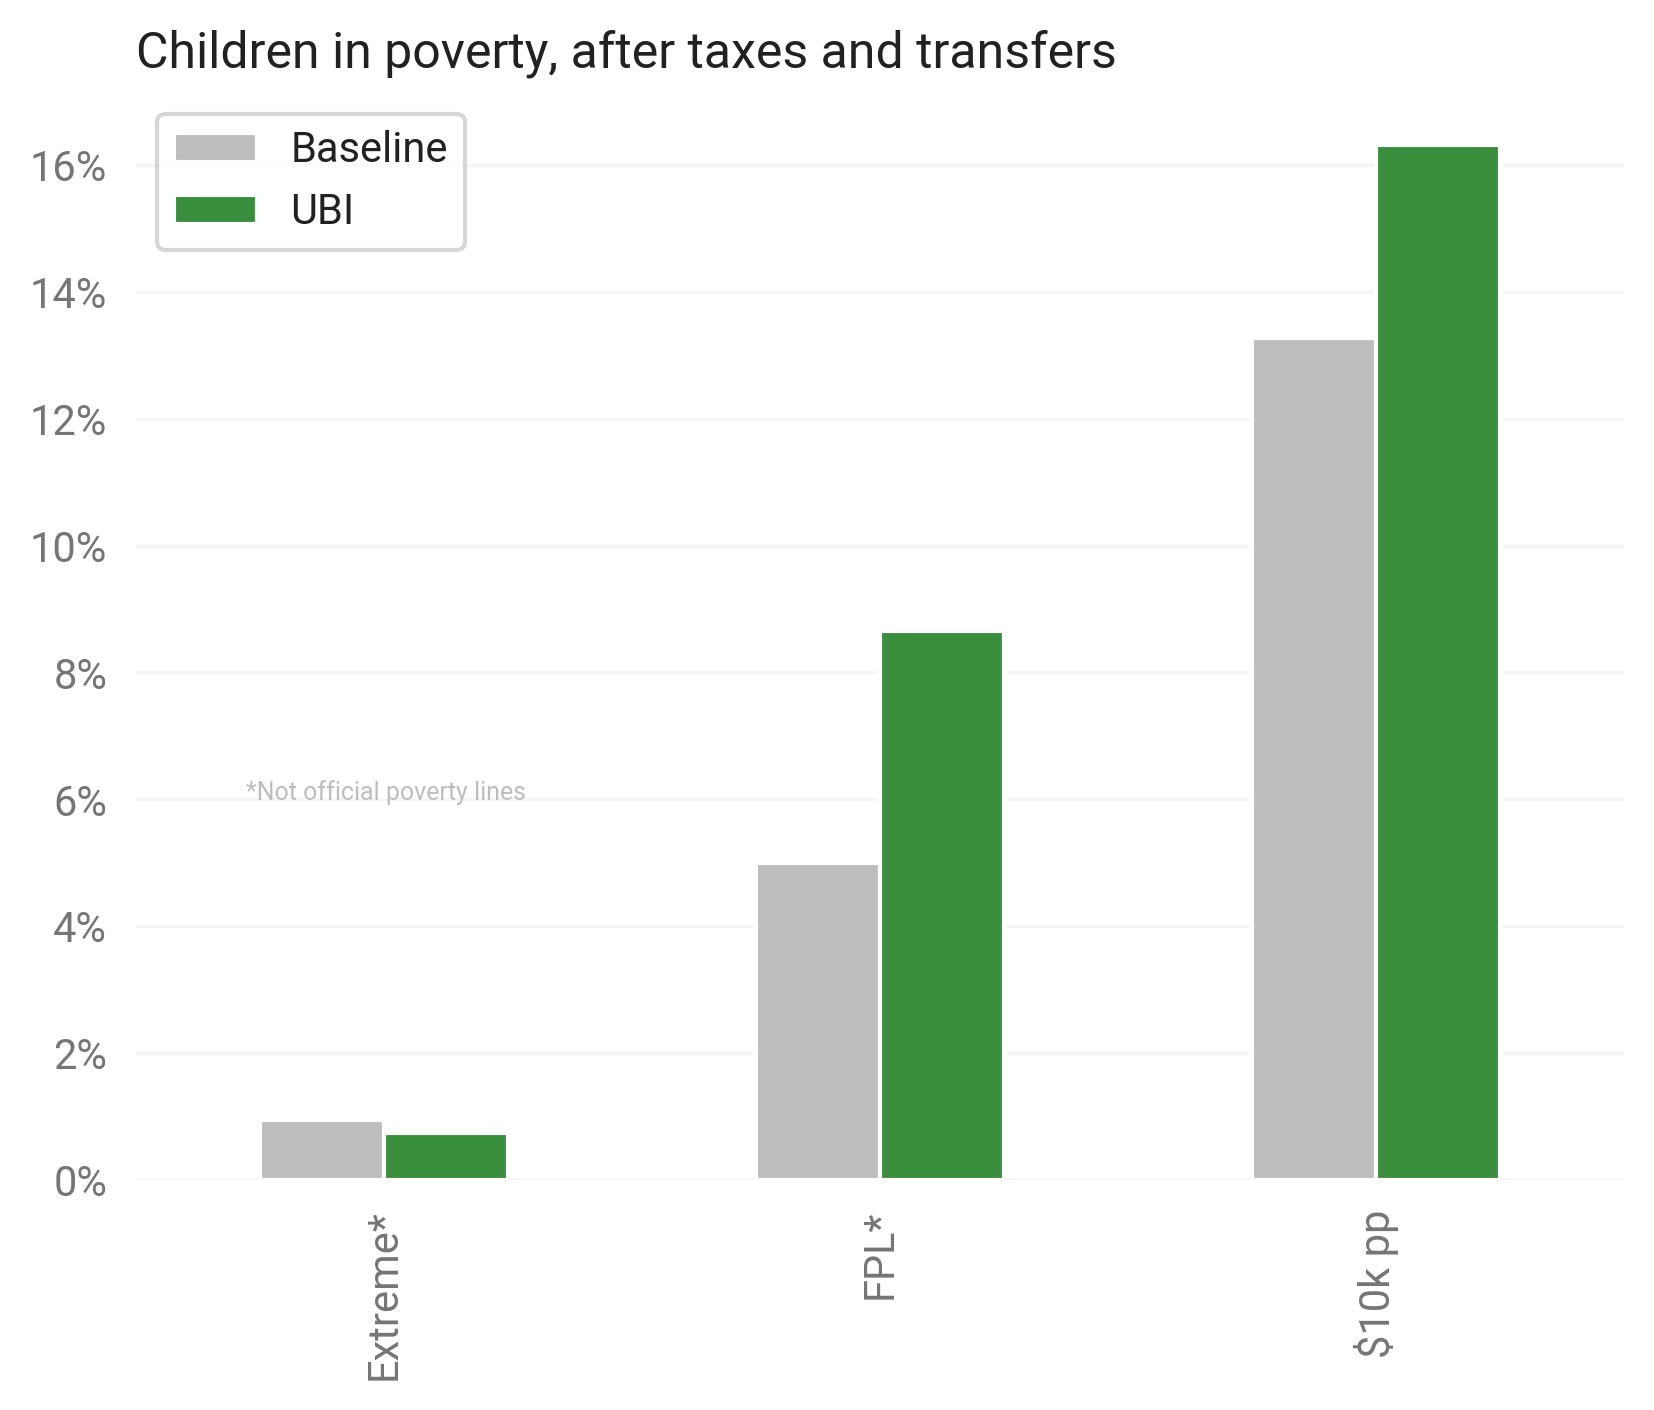

In [53]:
KEEP_COLOR = '#bdbdbd'  # Light gray from material.io/color.
UBI_COLOR = '#388e3c'
ax = pov_wide_nu18.plot.bar(color=[KEEP_COLOR, UBI_COLOR])
ax.set_xticklabels(('Extreme*', 'FPL*', '$10k pp'))
sns.despine(left=True, bottom=True)
# Use text instead of legend.
# ax.legend_.remove()
LEFT_X = -0.28
ax.legend(['Baseline', 'UBI'])
# ax.text(LEFT_X, 0.235, 'Repeal CTC', horizontalalignment='left',
#         color=REPEAL_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.225, 'No change to CTC', horizontalalignment='left',
#         color=KEEP_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.215, rn_ubi_str + ' child benefit', 
#         horizontalalignment='left', color=UBI_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.205, '$2,000 child benefit', 
#         horizontalalignment='left', color=TUBI_COLOR, size=8, weight='bold')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
plt.title('Children in poverty, after taxes and transfers', 
          loc='left')
ax.text(LEFT_X, 0.06, '*Not official poverty lines',
        horizontalalignment='left', color=KEEP_COLOR, size=6)
ax.set(xlabel='')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

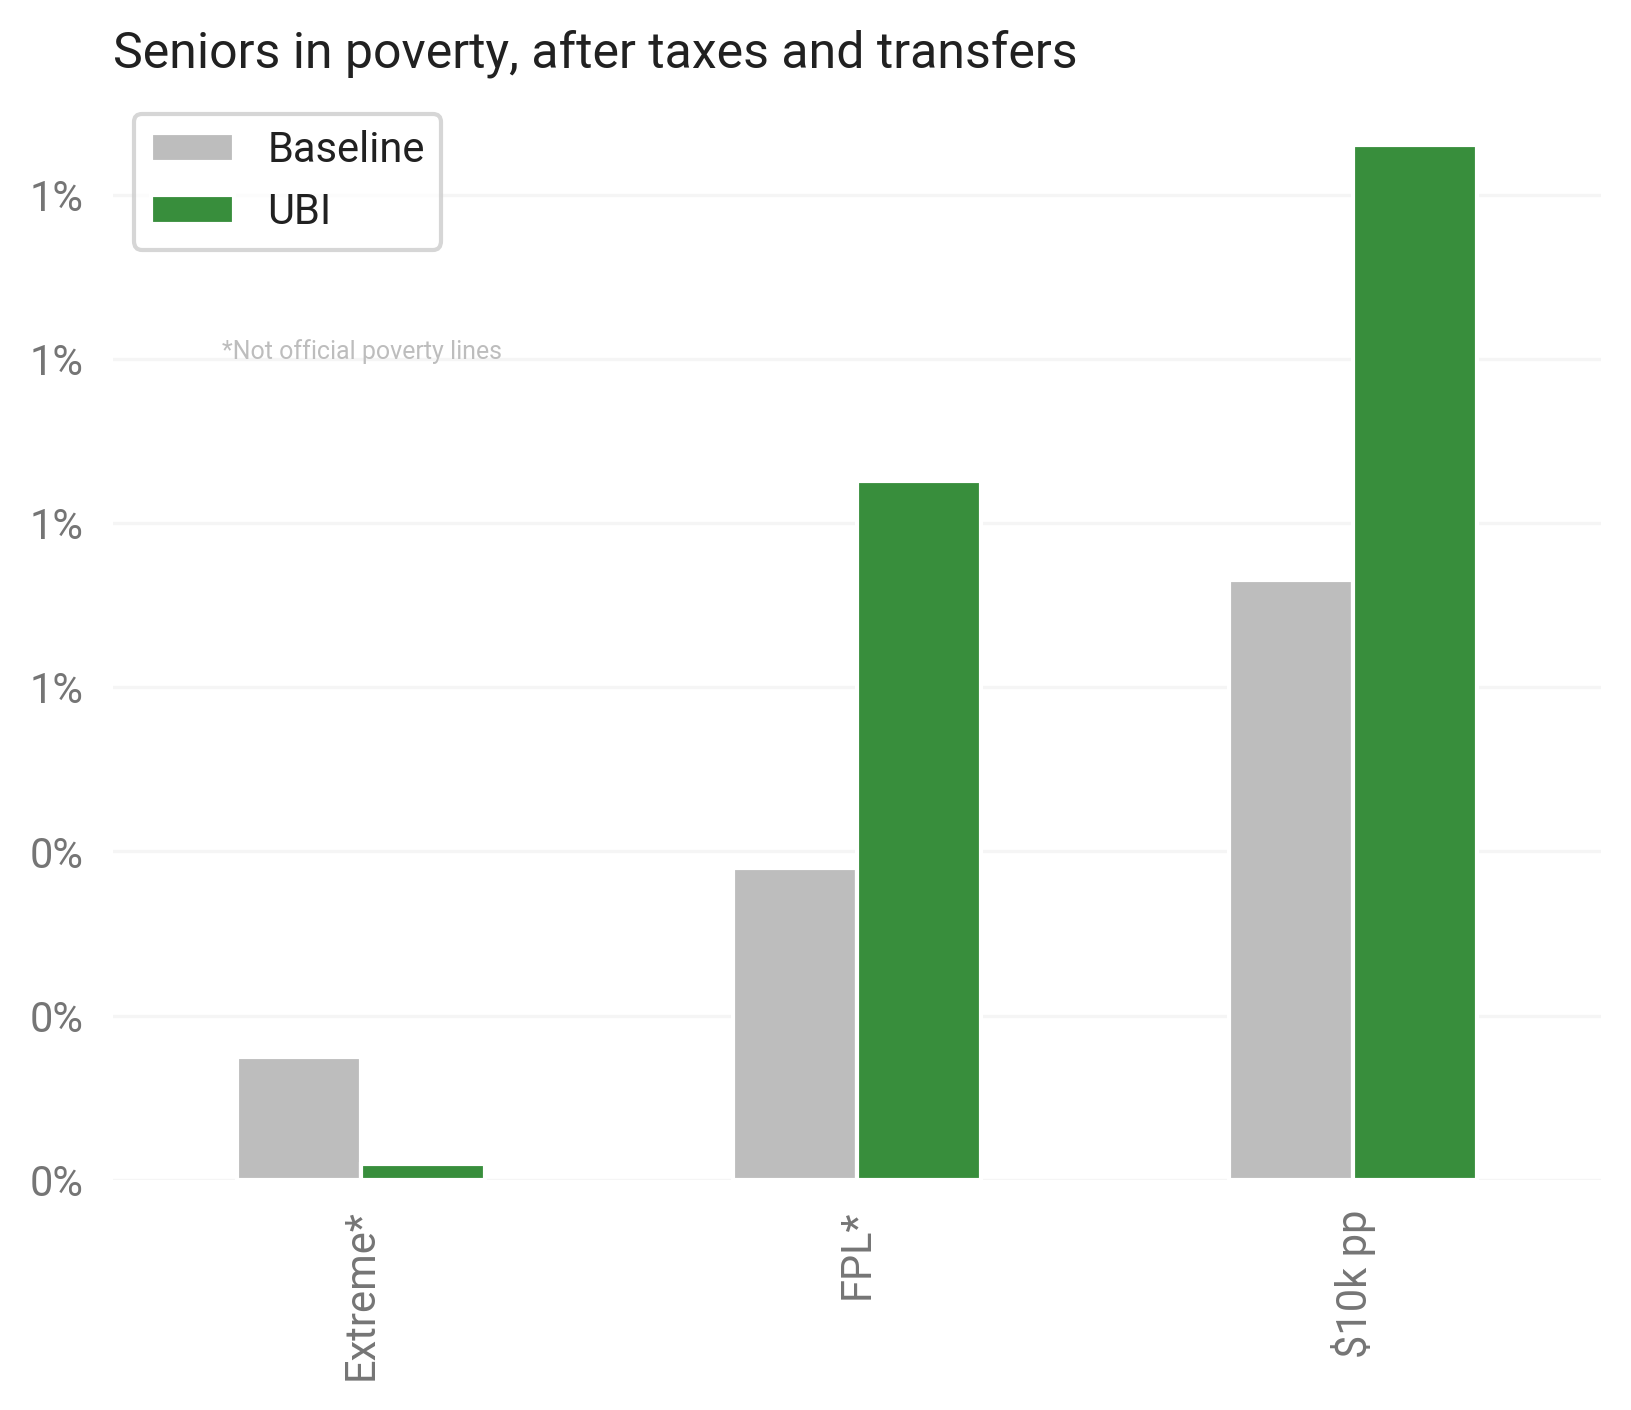

In [54]:
KEEP_COLOR = '#bdbdbd'  # Light gray from material.io/color.
UBI_COLOR = '#388e3c'
ax = pov_wide_n65.plot.bar(color=[KEEP_COLOR, UBI_COLOR])
ax.set_xticklabels(('Extreme*', 'FPL*', '$10k pp'))
sns.despine(left=True, bottom=True)
# Use text instead of legend.
# ax.legend_.remove()
LEFT_X = -0.28
ax.legend(['Baseline', 'UBI'])
# ax.text(LEFT_X, 0.235, 'Repeal CTC', horizontalalignment='left',
#         color=REPEAL_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.225, 'No change to CTC', horizontalalignment='left',
#         color=KEEP_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.215, rn_ubi_str + ' child benefit', 
#         horizontalalignment='left', color=UBI_COLOR, size=8, weight='bold')
# ax.text(LEFT_X, 0.205, '$2,000 child benefit', 
#         horizontalalignment='left', color=TUBI_COLOR, size=8, weight='bold')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
plt.title('Seniors in poverty, after taxes and transfers', 
          loc='left')
ax.text(LEFT_X, 0.01, '*Not official poverty lines',
        horizontalalignment='left', color=KEEP_COLOR, size=6)
ax.set(xlabel='')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

### Disruption

#### Share with >10% loss

In [55]:
(tu[(tu.afti_base > 0) & (tu.afti_pctchg > 10)].s006.sum() /
 tu[(tu.afti_base > 0)].s006.sum())

0.4986338543322194

In [56]:
(tu[(tu.afti_base > 0) & (tu.afti_pctchg < -30)].s006.sum() /
 tu[(tu.afti_base > 0)].s006.sum())

0.2169347440905617

In [57]:
# Use least or min instead.
tu['afti_pctchg_neg'] = np.where((tu.afti_pctchg > 0) | (tu.afti_base <= 0), 
                                 0, tu.afti_pctchg)

In [58]:
tu[tu.afti_pctchg_neg == tu.afti_pctchg_neg.min()][['afti_base', 'afti_ubi']]

,afti_base,afti_ubi
RECID,,
119534,17828.46,-36791.05


In [59]:
tu.afti_pctchg_neg.min()

-306.36140087805296

In [60]:
mdf.weighted_mean(tu, 'afti_pctchg_neg')

-13.296954967728844